# Тематическая классификация длинных текстов - TFIDF и LogReg

In [68]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [86]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import nltk
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Предобработка текстов и подготовка признаков

In [70]:
## подгружаем данные 
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [71]:
# токенезируем, разбиваем предложения на токены
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(train_tokenized[0])

['from', 'lerxst', 'where', 'thing', 'subject', 'what', 'this', 'nntp', 'posting', 'host', 'rac3', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'there', 'could', 'enlighten', 'this', 'other', 'door', 'sports', 'looked', 'from', 'late', 'early', 'called', 'bricklin', 'doors', 'were', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'from', 'rest', 'body', 'this', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'where', 'this', 'made', 'history', 'whatever', 'info', 'have', 'this', 'funky', 'looking', 'please', 'mail', 'thanks', 'brought', 'your', 'neighborhood', 'lerxst']


In [95]:
lemmatizer = WordNetLemmatizer()
train_tokenized = [[lemmatizer.lemmatize(w)  for w in lists ]for lists in train_tokenized]
test_tokenized = [[lemmatizer.lemmatize(w)  for w in lists ]for lists in test_tokenized]
print(train_tokenized[0])

['from', 'lerxst', 'where', 'thing', 'subject', 'what', 'this', 'nntp', 'posting', 'host', 'rac3', 'organization', 'university', 'maryland', 'college', 'park', 'line', 'wondering', 'anyone', 'there', 'could', 'enlighten', 'this', 'other', 'door', 'sport', 'looked', 'from', 'late', 'early', 'called', 'bricklin', 'door', 'were', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'from', 'rest', 'body', 'this', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'where', 'this', 'made', 'history', 'whatever', 'info', 'have', 'this', 'funky', 'looking', 'please', 'mail', 'thanks', 'brought', 'your', 'neighborhood', 'lerxst']


In [96]:
MAX_DF = 0.8
MIN_COUNT = 5
"""build_vocabulary строим словарь. Каждому токену присваеваем свой номер (кодируем слово под одним номером)
build_vocabulary - возращает 2 параметра
vocabulary - словарь - токины из нашей обучающ-ся выборки, с порядковым номером, отсортерованные по частоте встречаемости среди всех документов
word_doc_freq - относительноая частота встречаемости слова среди всех документов
max_doc_freq -  удаляем токины из ловаря, если они встречались более чем в 80% документов
min_count - удаляем токины, которые встречались меньше 5 раз
"""
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 19578
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


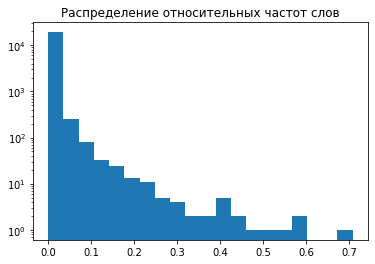

In [97]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [98]:
"""vectorize_texts - строим матрицу, кол-во строк = кол-ву текстов, кол-во столбцов = кол-ву слов
и заполняем в нашем случае ячейки матрицы tfidf
"""
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 19578)
Размерность матрицы признаков тестовой выборки (7532, 19578)

Количество ненулевых элементов в обучающей выборке 1105974
Процент заполненности матрицы признаков 0.50%

Количество ненулевых элементов в тестовой выборке 709349
Процент заполненности матрицы признаков 0.48%


In [99]:
train_vectors

<11314x19578 sparse matrix of type '<class 'numpy.float32'>'
	with 1105974 stored elements in Compressed Sparse Row format>

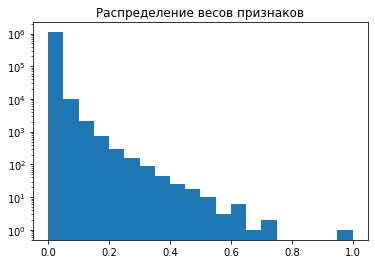

In [100]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [101]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


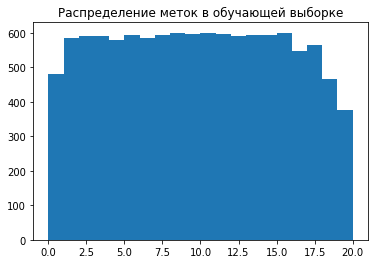

In [102]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

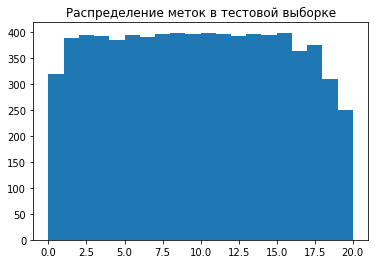

In [103]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [104]:
"""SparseFeaturesDataset - подключаем для удобства работы с разрежеными матрицами. 
теперь мы пожем получать определенные элемент в разреженной матрице в полном виде, 
все сотальные элементы, кроме этого, так и будут разрежеными """
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [109]:
""" моздаем по сути несколько логистический регрессий"""
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

"""train_eval_loop - обучает модель (учились этому на прошлом курсе)"""
best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 3.96 сек
Среднее значение функции потерь на обучении 2.2650583403258673
Среднее значение функции потерь на валидации 2.164438661882433
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 3.75 сек
Среднее значение функции потерь на обучении 0.9927731429116201
Среднее значение функции потерь на валидации 1.736058524604571
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 3.74 сек
Среднее значение функции потерь на обучении 0.5248118019373403
Среднее значение функции потерь на валидации 1.5057129056776983
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 3.84 сек
Среднее значение функции потерь на обучении 0.32624722863573813
Среднее значение функции потерь на валидации 1.3752704800690634
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 3.73 сек
Среднее значение функции потерь на обучении 0.22267551720142365
Среднее значение функции потерь на валидации 1.2910115812289513
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.78 сек
Среднее значение функции по

## Оценка качества

In [110]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 151.08it/s]


Среднее значение функции потерь на обучении 0.005251995287835598
Доля верных ответов 0.9992045253668022



236it [00:01, 155.03it/s]                             

Среднее значение функции потерь на валидации 0.9575307369232178
Доля верных ответов 0.7665958576739246


Доля верных ответов 0.76805629314923 на test


# Альтернативная реализация на scikit-learn

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

"""весь код выше, но в 5 строчках через sklearn """
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [108]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.49547889185785
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582336975
Доля верных ответов 0.8190387679235263
